# 旅行評分分析&預測

這次想要做到的是對於地點的星級評分,做基本的分析以及預測

## **給予一些 Feature,希望可以預測出對於某種類的評分label**

這裡希望可以預測出使用者會給出的約略評價

## Dataset介紹

Data Set Information:

This data set is populated by capturing user ratings from Google reviews. Reviews on attractions from 24 categories
across Europe are considered.
Google user rating ranges from 1 to 5 and average user rating per category is calculated.

## Attriube 介紹

|Attribute 1|Attribute 2|Attribute 3|Attribute 4|Attribute 5|
|---|---|---|---|---|
|User id|churches|resorts|beaches|parks|

|Attribute 6|Attribute 7|Attribute 8|Attribute 9|Attribute 10|
|---|---|---|---|---|
|theatres|museums|malls|zoo|restaurants|

|Attribute 11|Attribute 12|Attribute 13|Attribute 14|Attribute 15|
|---|---|---|---|---|
|pubs/bars|local services|burger/pizza shops|hotels/other lodgings|juice bars|

|Attribute 16|Attribute 17|Attribute 18|Attribute 19|Attribute 20|
|---|---|---|---|---|
|art galleries|dance clubs|swimming pools|gyms|bakeries|

|Attribute 21|Attribute 22|Attribute 23|Attribute 24|Attribute 25|
|---|---|---|---|---|
|beauty & spas|cafes|view points|monuments|gardens|

Attribute2-Attribute25 皆為這個User對於這類地點的平均評分
範圍是0.0-5.00

接下來就開始做prediction

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import random
from sklearn import linear_model, metrics, model_selection

讀入一些共用的function及檔案

In [51]:
#切割資料為testing set,training set
def train_test(data):
    # control randomization for reproducibility
    np.random.seed(42)
    random.seed(42)
    train, test = model_selection.train_test_split(data)
    return train,test

In [52]:
#切割資料為features 及label
def split(data):
    x_data = data.loc[:, train.columns != 'gardens']
    y_data = data['gardens']
    return x_data,y_data

In [53]:
#計算train,test正確率並回傳
def evaluate(model, train,test):
    x_train,y_train= split(train)
    x_test,y_test=split(test)
    model.fit(x_train, y_train)
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)
    train_acc = metrics.accuracy_score(y_train, train_preds)
    test_acc = metrics.accuracy_score(y_test, test_preds)
    return train_acc, test_acc

In [54]:
#Load file
file_name = 'google_review_ratings.csv'
data = pd.read_csv(file_name)
#ID 對於分析沒有實際意義,故drop
data=data.drop(["User","Unnamed: 25"],axis=1)
#從attribute 改為較有意義的column name
columnList=[
    'churches',
    'resorts',
    'beaches',
    'parks',
    'theatres',
    'museums',
    'malls',
    'zoo',
    'restaurants',
    'pubs/bars',
    'local services',
    'burger/pizza shops',
    'hotels/other lodgings',
    'juice bars',
    'art galleries',
    'dance clubs',
    'swimming pools',
    'gyms',
    'bakeries',
    'beauty & spas',
    'cafes',
    'view points',
    'monuments',
    'gardens',
]
data.columns = columnList
data.fillna(0,inplace=True)

#local services 有部份不是float所以先捨棄
data=data.drop(["local services"],axis=1)
columnList.remove("local services")

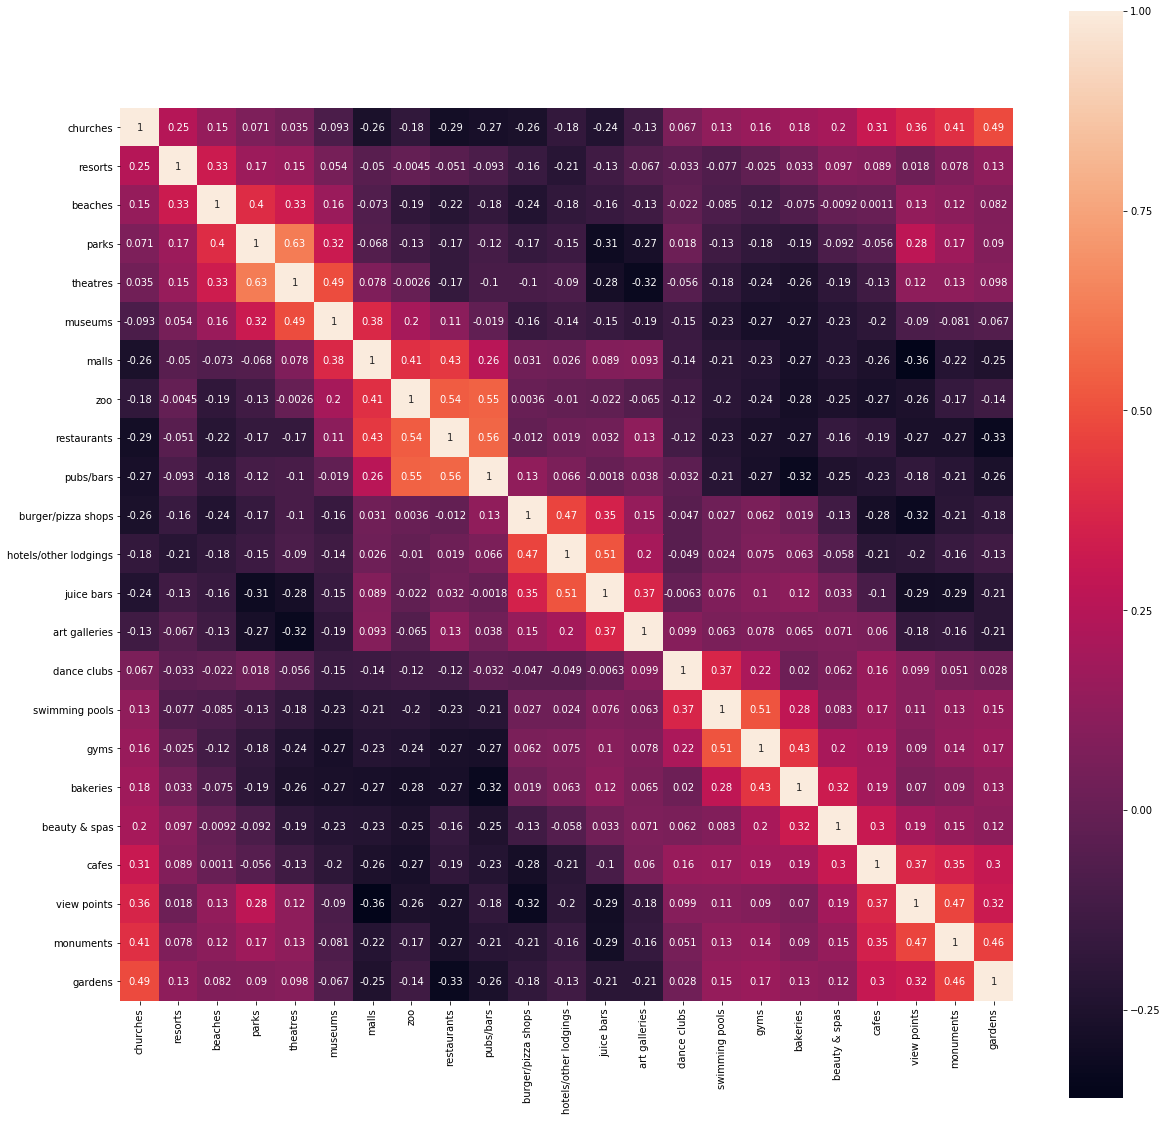

In [55]:
plt.figure(figsize=(20,20))
heatmap=sb.heatmap(data.corr(), square=True, annot=True)
plt.show()

# 問題點

**這個 dataset 資料很稀疏,預測準確值不容易**

**Dataset 相關係數有相關的不多,也導致不好判斷**

所以才打算使用約略評估來作為預測結果

```
0.00-1.67 -> bad -> -1

1.68-3.33 -> normal -> 0

3.34-5.00 -> good -> 1
```

因為是粗估所以就做One-hot coding把資料轉成-1,0,1,算是做一種data mapping

原本想要做**normalization但是皆為0.00-5.00故不需要做**

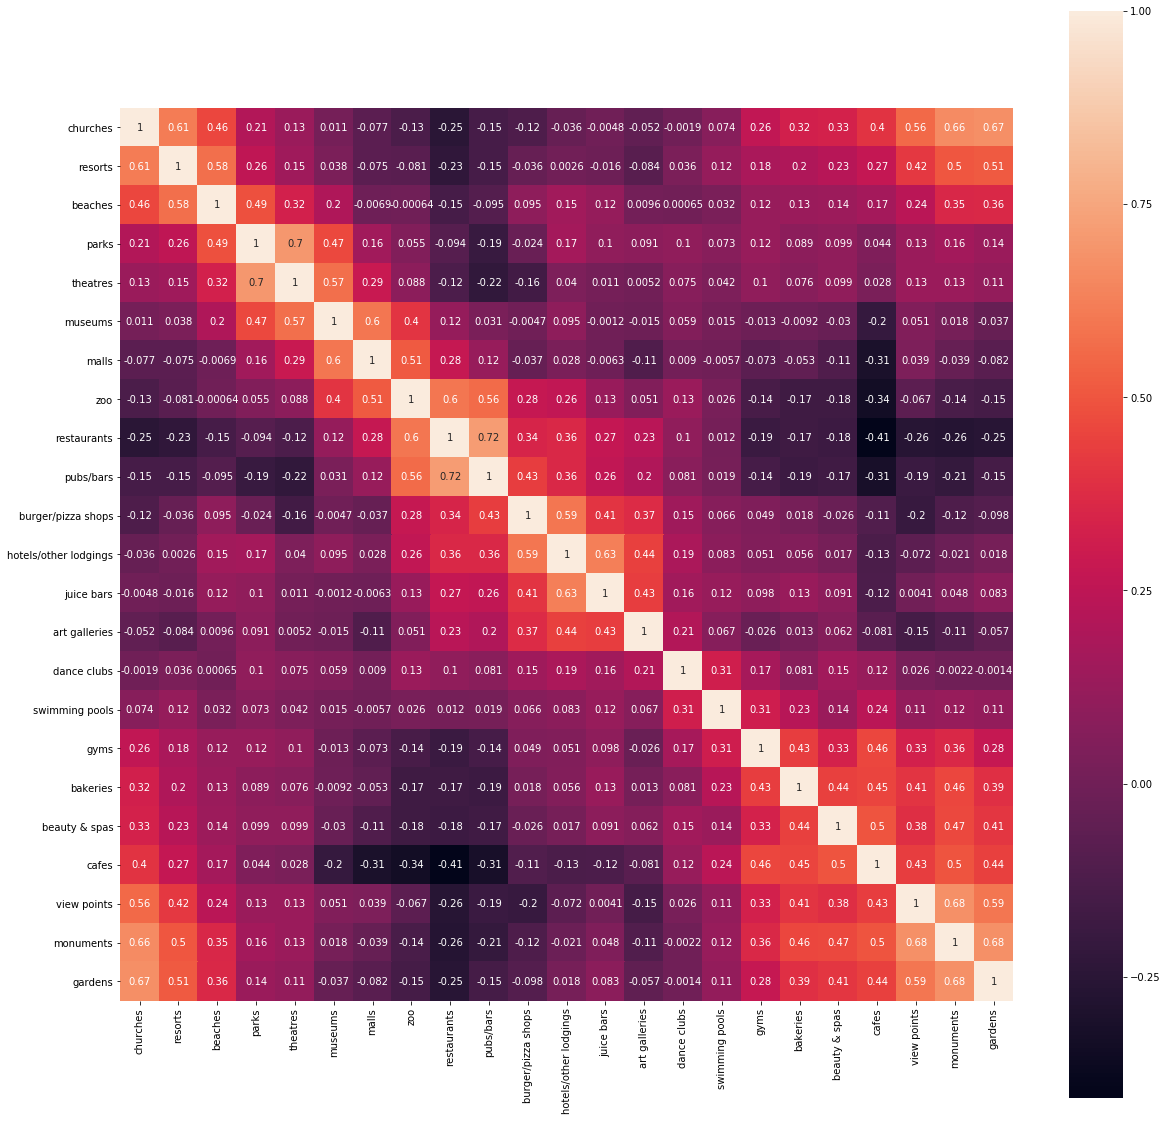

In [56]:
#One hot encoding
for column in columnList:
    data.loc[data[column] <=1.67, column] = -1
    data.loc[data[column] >=3.34, column] = 0
    data.loc[data[column] >=1.68, column] = 1
    
plt.figure(figsize=(20,20))
heatmap=sb.heatmap(data.corr(), square=True, annot=True)

相較於原本沒有做one-hot encoding上張整體相關係數有上升

接下來是開始做預測的training set,testing set

# Prediction

## 預測最後一個column(garden)當作label

In [57]:
#切出 test,train
#以及切出feature,label
train,test= train_test(data)
x_train,y_train=split(train)
x_test,y_test=split(test)

# Approach 1
先用Linear Regression,及 logistic regression看一下正確率

## Linear Regression

In [58]:
# declare variables
max_test_acc=0
min_test_acc=1
max_train_acc=0
min_train_acc=1
times=10

# start training model
for i in range(0,times):
    model_bl = linear_model.SGDClassifier(loss='log', max_iter=10000,tol=0.21)
    train_acc,test_acc =evaluate(model_bl, train,test)
    if(max_test_acc<test_acc):
        max_test_acc=test_acc
    if(min_test_acc>test_acc):
        min_test_acc=test_acc
    if(max_train_acc<train_acc):
        max_train_acc=train_acc
    if(min_train_acc>train_acc):
        min_train_acc=train_acc

print('Min train accuracy: '+ str(min_train_acc))
print('Max train accuracy: '+ str(max_train_acc))
print('------------------------------')
print('Min test accuracy: '+ str(min_test_acc))
print('Max test accuracy: '+ str(max_test_acc))

Min train accuracy: 0.8169599217986315
Max train accuracy: 0.8665689149560117
------------------------------
Min test accuracy: 0.8137829912023461
Max test accuracy: 0.8592375366568915


## Logistic Regression

In [59]:
# declare variables
max_test_acc=0
min_test_acc=1
max_train_acc=0
min_train_acc=1
times=10

# start training model
for i in range(0,times):
    x_train,y_train= split(train)
    x_test,y_test=split(test)
    clf = linear_model.LogisticRegression(multi_class="auto",solver="lbfgs" ,max_iter=100,penalty='l2')
    train_acc,test_acc = evaluate(clf, train,test)
    if(max_test_acc<test_acc):
        max_test_acc=test_acc
    if(min_test_acc>test_acc):
        min_test_acc=test_acc
    if(max_train_acc<train_acc):
        max_train_acc=train_acc
    if(min_train_acc>train_acc):
        min_train_acc=train_acc

print('Min train accuracy: '+ str(min_train_acc))
print('Max train accuracy: '+ str(max_train_acc))
print('------------------------------')
print('Min test accuracy: '+ str(min_test_acc))
print('Max test accuracy: '+ str(max_test_acc))

Min train accuracy: 0.863147605083089
Max train accuracy: 0.863147605083089
------------------------------
Min test accuracy: 0.8519061583577713
Max test accuracy: 0.8519061583577713


# Approach 2

兩者都有85%的accuracy,還不算差

這裡就選擇Logistic Regression作為訓練model

但是可以從相對係數的heatmap看到不少相對係數低於0.1的features

## 把相關係數不大的feature捨去,因為其實對於accuracy影響不大

**可以增加training速度,或許也可以增加accuracy**

In [60]:
data=data.drop(["museums","malls","burger/pizza shops","hotels/other lodgings","juice bars","art galleries","dance clubs"],axis=1)

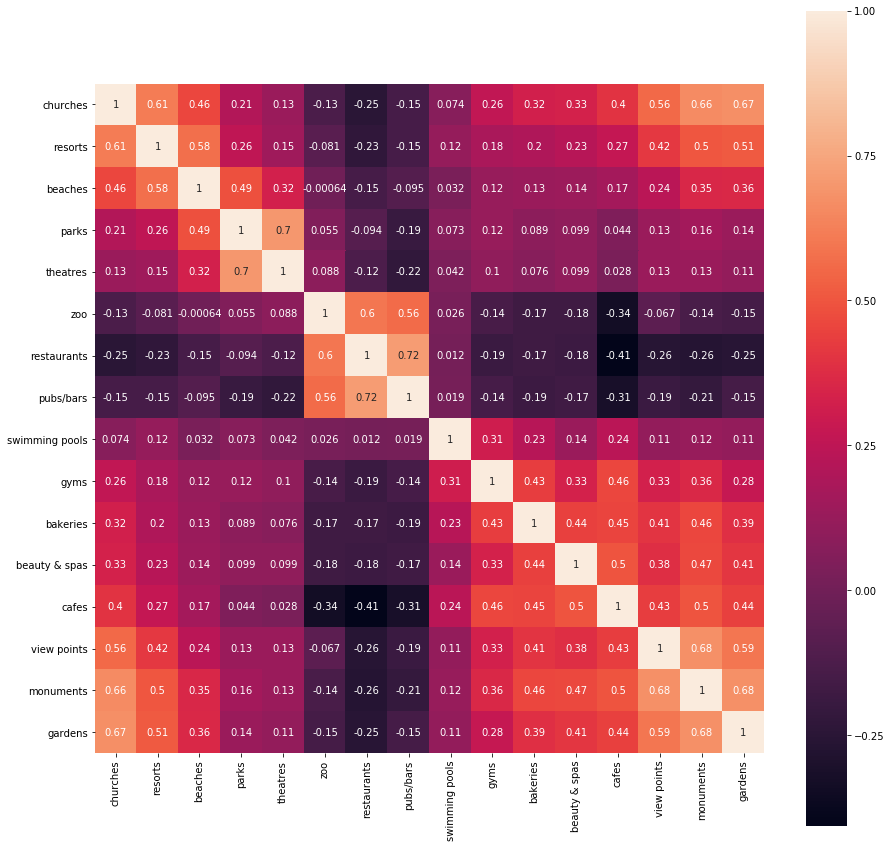

In [61]:
plt.figure(figsize=(15,15))
heatmap=sb.heatmap(data.corr(), square=True, annot=True)

可以看出label少了不少,圖可以變小張了

接下來重切一次training set,testing set

In [62]:
train,test= train_test(data)
x_train,y_train=split(train)
x_test,y_test=split(test)

In [63]:
# declare variables
max_test_acc=0
min_test_acc=1
max_train_acc=0
min_train_acc=1
times=10

# start training model
for i in range(0,times):
    x_train,y_train= split(train)
    x_test,y_test=split(test)
    clf = linear_model.LogisticRegression(multi_class="auto",solver="lbfgs" ,max_iter=100,penalty='l2')
    train_acc,test_acc = evaluate(clf, train,test)
    if(max_test_acc<test_acc):
        max_test_acc=test_acc
    if(min_test_acc>test_acc):
        min_test_acc=test_acc
    if(max_train_acc<train_acc):
        max_train_acc=train_acc
    if(min_train_acc>train_acc):
        min_train_acc=train_acc

print('Min train accuracy: '+ str(min_train_acc))
print('Max train accuracy: '+ str(max_train_acc))
print('------------------------------')
print('Min test accuracy: '+ str(min_test_acc))
print('Max test accuracy: '+ str(max_test_acc))

Min train accuracy: 0.8624144672531769
Max train accuracy: 0.8624144672531769
------------------------------
Min test accuracy: 0.8519061583577713
Max test accuracy: 0.8519061583577713


可以看的出來trining accuracy掉了極微小的值`0.863147605083089->0.8624144672531769`

而testing accuracy則完全沒有掉

所以把features去除掉是OK的

# Approach 3

之前上課有介紹到SVM,他的想法和Logistic regression類似

但是可惜的地方是**SVM在處理數值(未normalized)及feature多時相當慢**

但是這次是使用one-hot encoding過,**數值相當整齊(-1,0,1)**

剛剛也有做**feature filter**

## 這裡就試看看用SVM去做

這裡有提供為何慢的原因 https://stackoverflow.com/questions/40077432/scikit-learn-svm-svc-is-extremely-slow

In [64]:
#做 Data scaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm

scaler = StandardScaler()
scaler.fit(x_train)

x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

In [65]:
#declare variables
penalty = 0.1

model = svm.SVC(C=penalty, kernel="linear", probability=True)
train_acc, test_acc= evaluate(model, train,test)

print('Train accuracy: '+ str(test_acc))
print('------------------------------')
print('Test accuracy: '+ str(train_acc))

Train accuracy: 0.8401759530791789
------------------------------
Test accuracy: 0.8511730205278593


# Approach 4

這裡用的是linear的kernel,感覺效果並沒有很好

在SVM裡有poly及linear的kernel,如果用的是linear則和原本的Logistic regression差不多

## 這裡把linear換成poly再度train一次

這裡有對於linear及poly的比較 https://www.kdnuggets.com/2016/06/select-support-vector-machine-kernels.html

In [66]:
#declare variables
penalty = 0.1

model = svm.SVC(C=penalty, kernel="poly", probability=True)
train_acc, test_acc= evaluate(model, train,test)

print('Train accuracy: '+ str(test_acc))
print('------------------------------')
print('Test accuracy: '+ str(train_acc))

/home/divik/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train accuracy: 0.8577712609970675
------------------------------
Test accuracy: 0.8682795698924731


# Approach 5

有看到Test accuracy及Train accuracy都上升了1%,**開始比logistic 好了**

但是我們可以繼續優化它,我們可以調整SVM的penalty來增加他的分隔強度

上面用的是0.1其實不怎麼高

## 我們可以改高做嘗試

In [67]:
#declare variables
penalty = 1

model = svm.SVC(C=penalty, kernel="poly", probability=True)
train_acc, test_acc= evaluate(model, train,test)

print('Train accuracy: '+ str(test_acc))
print('------------------------------')
print('Test accuracy: '+ str(train_acc))

/home/divik/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train accuracy: 0.8709677419354839
------------------------------
Test accuracy: 0.8826979472140762


## 再高一點!

In [68]:
#declare variables
penalty = 10

model = svm.SVC(C=penalty, kernel="poly", probability=True)
train_acc, test_acc= evaluate(model, train,test)

print('Train accuracy: '+ str(test_acc))
print('------------------------------')
print('Test accuracy: '+ str(train_acc))

/home/divik/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train accuracy: 0.8841642228739003
------------------------------
Test accuracy: 0.9042033235581622


## 再..再高一點

In [69]:
#declare variables
penalty = 100

model = svm.SVC(C=penalty, kernel="poly", probability=True)
train_acc, test_acc= evaluate(model, train,test)

print('Train accuracy: '+ str(test_acc))
print('------------------------------')
print('Test accuracy: '+ str(train_acc))

/home/divik/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train accuracy: 0.8834310850439883
------------------------------
Test accuracy: 0.9193548387096774


## 再高一點點就好RRR

In [70]:
#declare variables
penalty = 1000

model = svm.SVC(C=penalty, kernel="poly", probability=True)
train_acc, test_acc= evaluate(model, train,test)

print('Train accuracy: '+ str(test_acc))
print('------------------------------')
print('Test accuracy: '+ str(train_acc))

/home/divik/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train accuracy: 0.8804985337243402
------------------------------
Test accuracy: 0.9308406647116324


# 結語

我們最後的test accuracy 為93%其實相當高,但是留下一個疑問

## Overfitting?

我們可能把penalty調整的太大了,會變成對每個點都做special case

## 解法？

我們可能還需要一個validation set來確定我們的結果是緊密&準確的(low bias & variance)

沒有不小心對testing set,training set做overfitting

但是這一次並沒有切出validation set來做